In [218]:
import numpy as np
from scipy.spatial import Delaunay, KDTree
import matplotlib.pyplot as plt

# Step 1: Preprocess the core data
def preprocess_cores(cores):
    """
    Preprocess the core data to normalize positions, inverting the y-axis so that
    the numbering starts from the top left corner.
    :param cores: List of dictionaries with 'x', 'y', and 'radius' keys.
    :return: Normalized list of core coordinates with the y-axis inverted.
    """
    coordinates = np.array([(core['x'], core['y']) for core in cores])
    min_x, max_y = np.min(coordinates[:, 0]), np.max(coordinates[:, 1])
    normalized_inverted_coordinates = np.array([(x - min_x, max_y - y) for x, y in coordinates])
    return normalized_inverted_coordinates

import numpy as np
from scipy.spatial import Delaunay
from sklearn.cluster import KMeans

# Step 1: Perform Delaunay triangulation and get all edges
def get_all_edges_from_triangulation(triangulation):
    edges = set()
    # For each triangle, add edges to the set, avoiding duplicates
    for simplex in triangulation.simplices:
        for i in range(3):
            edge = tuple(sorted([simplex[i], simplex[(i + 1) % 3]]))
            edges.add(edge)
    return np.array(list(edges))


# Step 2: Delaunay triangulation
def delaunay_triangulation(coordinates):
    """
    Perform Delaunay triangulation on the coordinates.
    :param coordinates: Array of coordinates.
    :return: Delaunay object containing the triangulation.
    """
    return Delaunay(coordinates)

# Step 2: Edge length filtering function
# def filter_edges_by_length(edges, coordinates, threshold_multiplier=1.5):
#     edge_lengths = [np.linalg.norm(coordinates[edge[0]] - coordinates[edge[1]]) for edge in edges]
#     edge_lengths = np.array(edge_lengths)
    
#     Q1, Q3 = np.percentile(edge_lengths, [25, 75])
#     IQR = Q3 - Q1
#     lower_bound = Q1 - (threshold_multiplier * IQR)
#     upper_bound = Q3 + (threshold_multiplier * IQR)

#     # We don't care about getting rid of all the short edges, just the really long ones
#     filtered_edges = edges[(edge_lengths <= upper_bound)]
#     # filtered_edges = edges[(edge_lengths >= lower_bound) & (edge_lengths <= upper_bound)]
    

#     return filtered_edges
def filter_edges_by_length(edges, coordinates, threshold_multiplier=1.5):
    # Calculate the edge lengths
    edge_lengths = [np.linalg.norm(coordinates[edge[0]] - coordinates[edge[1]]) for edge in edges]
    edge_lengths = np.array(edge_lengths)
    
    # Calculate the median and the median absolute deviation (MAD)
    median = np.median(edge_lengths)
    mad = np.median(np.abs(edge_lengths - median))
    
    # Calculate the bounds based on the median and MAD
    lower_bound = median - (threshold_multiplier * mad)
    upper_bound = median + (threshold_multiplier * mad)

    # Filter edges within the MAD bounds
    filtered_edge_indices = np.where((edge_lengths >= lower_bound) & (edge_lengths <= upper_bound))[0]
    filtered_edges = [edges[index] for index in filtered_edge_indices]

    return filtered_edges

# Step 3: Angle filtering function
# from sklearn.cluster import KMeans

# def filter_edges_by_angle(edges, coordinates, delta=0):
#     # Calculate edge angles and adjust by δ
#     angles = np.array([np.arctan2(coordinates[edge[1]][1] - coordinates[edge[0]][1], 
#                                    coordinates[edge[1]][0] - coordinates[edge[0]][0])
#                        for edge in edges])
    
#     # Normalize angles to [0, 2*pi) and adjust by delta
#     angles = (angles + delta) % (2 * np.pi)
    
#     # Use k-means clustering to find clusters around expected angles
#     kmeans = KMeans(n_clusters=5)
#     kmeans.fit(angles.reshape(-1, 1))
    
#     # Determine which cluster corresponds to near-horizontal angles
#     # This requires examining the cluster centers and selecting the one closest to 0 + δ or π + δ
#     cluster_centers = kmeans.cluster_centers_.flatten()
#     horizontal_clusters = []
#     for expected_angle in [0, np.pi]:  # Horizontal angles adjusted by δ
#         adjusted_angle = (expected_angle + delta) % (2 * np.pi)
#         horizontal_clusters.append(np.argmin(np.abs(cluster_centers - adjusted_angle)))
    
#     # Filter edges based on their cluster label being one of the horizontal clusters
#     filtered_edge_indices = np.isin(kmeans.labels_.flatten(), horizontal_clusters)
#     filtered_edges = np.array(edges)[filtered_edge_indices]
    
#     return filtered_edges

def filter_edges_by_angle(edges, coordinates, tolerance=10):
    tolerance = np.radians(tolerance)
    # Calculate edge angles
    angles = np.array([np.arctan2(coordinates[edge[1]][1] - coordinates[edge[0]][1], 
                                   coordinates[edge[1]][0] - coordinates[edge[0]][0])
                       for edge in edges])
    
    # Normalize angles to [0, 2*pi) range
    angles = np.mod(angles, 2 * np.pi)
    
    # Determine if an angle is within the tolerance of horizontal (0 or π radians)
    is_horizontal = (np.abs(angles) <= tolerance) | (np.abs(angles - np.pi) <= tolerance)
    
    # Filter edges that are considered horizontal
    horizontal_edges = np.array(edges)[is_horizontal]
    
    return horizontal_edges.tolist()





In [245]:
import numpy as np

# Helper function to calculate distance between two points
def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Helper function to calculate the angle between two points with respect to the x-axis
def angle_with_x_axis(p1, p2):
    return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

# Helper function to check if a point is within the circular sector
def point_in_sector(V_prime, Vj, r, phi, origin_angle):
    phi_rad = np.radians(phi)
    origin_angle_rad = np.radians(origin_angle)
    angle_Vj_V_prime = angle_with_x_axis(Vj, V_prime) % (2 * np.pi)
    
    start_angle = (origin_angle_rad - phi_rad / 2) % (2 * np.pi)
    end_angle = (origin_angle_rad + phi_rad / 2) % (2 * np.pi)

    if start_angle > end_angle:  # Sector crosses the 0 radians line
        return calculate_distance(V_prime, Vj) <= r and (angle_Vj_V_prime >= start_angle or angle_Vj_V_prime <= end_angle)
    else:
        return calculate_distance(V_prime, Vj) <= r and start_angle <= angle_Vj_V_prime <= end_angle

# Helper function to check if point is within the image width threshold
def is_close_to_image_width(point, image_width, gamma):
    return abs(point[0] - image_width) < gamma


# Main traveling algorithm
def traveling_algorithm(S, image_width, d, gamma):
    A = []  # Final list of rows of centroids
    r = 1.5 * d  # Radius for sector search
    imaginary_points_index = -1  # Start an index for imaginary points
    
    # Ensure S is a list of dictionaries with 'start', 'end', 'index', and 'is_imaginary' keys
    S = [{'start': np.array(v[0]), 'end': np.array(v[1]), 'index': i, 'is_imaginary': False} for i, v in enumerate(S)]
    
    while S:
        # Find the start vector with the smallest x-coordinate in the first point of the vector
        start_vector = min(S, key=lambda v: v['start'][0])
        A1 = [start_vector]  # Start with the vector with the smallest x
        Vj = start_vector['end']  # Current endpoint is the second element of the first vector

        # Remove the start vector from S by filtering
        S = [vector for vector in S if vector['index'] != start_vector['index']]

        # Iterative Traveling
        while True:
            next_vector = next((v for v in S if np.array_equal(v['start'], Vj)), None)
            if next_vector:
                Vj = next_vector['end']
                A1.append(next_vector)
                S = [vector for vector in S if vector['index'] != next_vector['index']]
            else:
                
                if not is_close_to_image_width(Vj, image_width, gamma):
                    # Add the last real point in the row to A1. Not sure what the index should be
                    candidates = [v for v in S if point_in_sector(v['end'], Vj, r, 360, 0)]
                    if candidates:
                        closest_vector = min(candidates, key=lambda v: calculate_distance(v['end'], Vj))
                        Vj = closest_vector['end']
                        A1.append(closest_vector)
                        S = [vector for vector in S if vector['index'] != closest_vector['index']]
                    else:
                        # Add an imaginary point to the right of the current point
                        delta_rad = np.radians(0)  # Angle for imaginary point is 0 radians
                        Vj_prime = np.array([Vj[0] + d * np.cos(delta_rad), Vj[1] + d * np.sin(delta_rad)])
                        imaginary_vector = {'start': Vj, 'end': Vj_prime, 'index': imaginary_points_index, 'is_imaginary': True}
                        imaginary_points_index -= 1  # Decrement to keep imaginary indices unique and negative
                        A1.append(imaginary_vector)
                        Vj = Vj_prime
                else:

                    A.append([{'point': vec['start'], 'index': vec['index'], 'is_imaginary': vec['is_imaginary']} for vec in A1])
                    if S:
                        break  # Exit the inner loop to start a new row
                    else:
                        return A  # If S is empty, we are done

        # Prepare for the next row
        A1 = []  # Clear A1 for the next row

    return A


In [217]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def visualize_delaunay_triangulation(coordinates, triangulation):
    plt.figure(figsize=(10, 6))
    plt.triplot(coordinates[:, 0], coordinates[:, 1], triangulation.simplices, color='grey', alpha=0.5)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Initial Delaunay Triangulation')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def visualize_edge_length_filtering(coordinates, edges):
    lines = [coordinates[list(edge)] for edge in edges]
    lc = LineCollection(lines, colors='blue', linewidths=1)
    
    plt.figure(figsize=(10, 6))
    plt.gca().add_collection(lc)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Edge Length Filtering')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def visualize_edge_angle_filtering(coordinates, edges):
    lines = [coordinates[list(edge)] for edge in edges]
    lc = LineCollection(lines, colors='red', linewidths=1)
    
    plt.figure(figsize=(10, 6))
    plt.gca().add_collection(lc)
    plt.plot(coordinates[:, 0], coordinates[:, 1], 'o', color='black')
    plt.title('Edge Angle Filtering')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def visualize_traveling_algorithm(coordinates, path):
    path_coords = coordinates[path]
    
    plt.figure(figsize=(10, 6))
    plt.plot(path_coords[:, 0], path_coords[:, 1], 'o-', color='green')
    plt.title('Traveling Algorithm Path')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

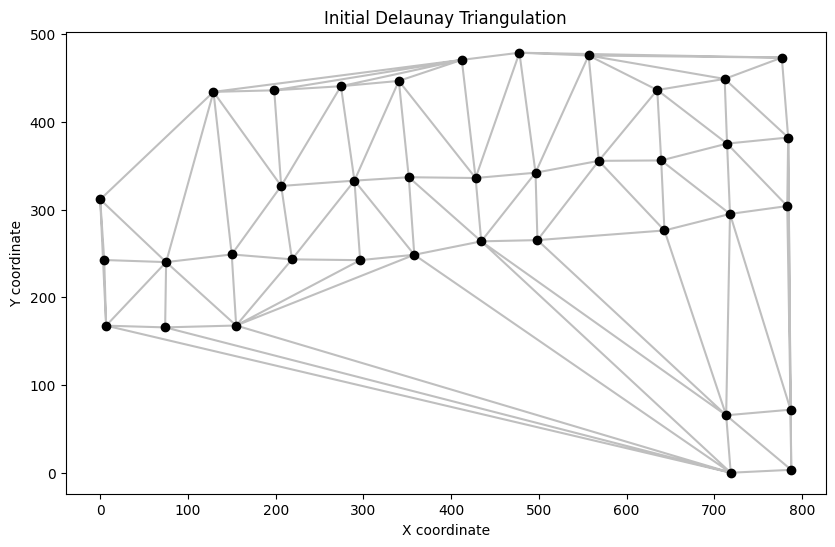

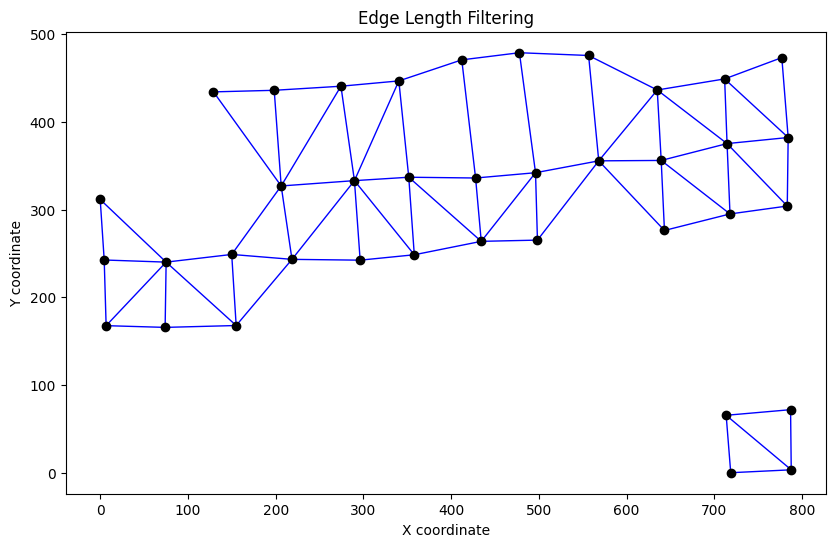

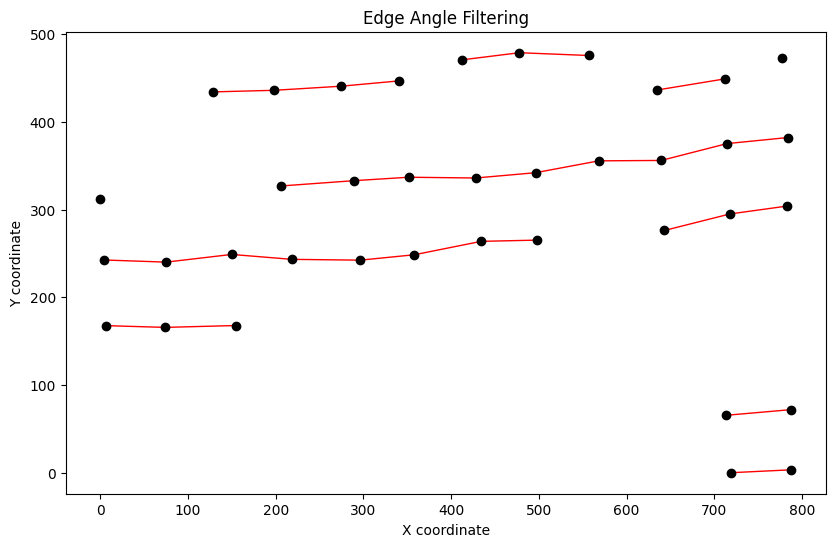

In [205]:
import pandas as pd
# Main workflow
data = pd.read_json('./TMA_WSI_Labels_updated/ABC_109_1_010_1.json')
data = data.to_dict('records')

# Convert the data to the required format if necessary
cores = data  # Assuming 'data' is already in the correct format

# Perform initial Delaunay triangulation
# Example usage in the pipeline
normalized_coordinates = preprocess_cores(data)
triangulation = Delaunay(normalized_coordinates)
visualize_delaunay_triangulation(normalized_coordinates, triangulation)


all_edges = get_all_edges_from_triangulation(triangulation)
length_filtered_edges = filter_edges_by_length(all_edges, normalized_coordinates, 1.5)
angle_filtered_edges = filter_edges_by_angle(length_filtered_edges, normalized_coordinates, tolerance=15)

# Example usage:
# Assume `filtered_edges` is a list of tuples (or sets) representing the remaining edges after filtering,
# `core_to_core_distance` is the average distance between cores,
# and `delta` is the angular tolerance in degrees for horizontal traversal.


# The `rows` variable contains lists of core indices, where each list represents a row in the grid.

visualize_edge_length_filtering(normalized_coordinates, length_filtered_edges)
visualize_edge_angle_filtering(normalized_coordinates, angle_filtered_edges)

# visualize_traveling_algorithm(normalized_coordinates, path)



In [206]:
# Sort the edges to ensure the arrow goes from left to right
sorted_edges = []
for edge in angle_filtered_edges:
    start, end = edge
    if normalized_coordinates[start][0] > normalized_coordinates[end][0]:
        # Swap the start and end points
        sorted_edges.append((end, start))
    else:
        sorted_edges.append((start, end))

In [207]:
traveling_algorithm_input = [normalized_coordinates[list(edge)] for edge in sorted_edges]
# print(traveling_algorithm_input)
print(traveling_algorithm_input)

[array([[296.31535216, 242.29157243],
       [358.02899469, 248.44501848]]), array([[129.13452884, 434.11730518],
       [198.34556842, 435.91646118]]), array([[643.177647  , 276.15166085],
       [717.8975956 , 294.97811452]]), array([[  4.55771093, 242.48727635],
       [ 75.15266041, 240.06572382]]), array([[412.14899378, 470.60999009],
       [477.85113844, 478.75421954]]), array([[717.8975956 , 294.97811452],
       [783.17359998, 303.99049047]]), array([[358.02899469, 248.44501848],
       [434.35203594, 263.74605225]]), array([[434.35203594, 263.74605225],
       [498.40784599, 265.14360438]]), array([[496.21769312, 341.97915903],
       [568.28669787, 355.5003455 ]]), array([[568.28669787, 355.5003455 ],
       [639.46929822, 355.96095422]]), array([[351.724129  , 336.82488351],
       [427.89593756, 335.94661426]]), array([[634.96967685, 436.27195016],
       [711.78082383, 448.89071121]]), array([[206.29949685, 326.87824488],
       [289.80278098, 332.94496366]]), array([[ 75

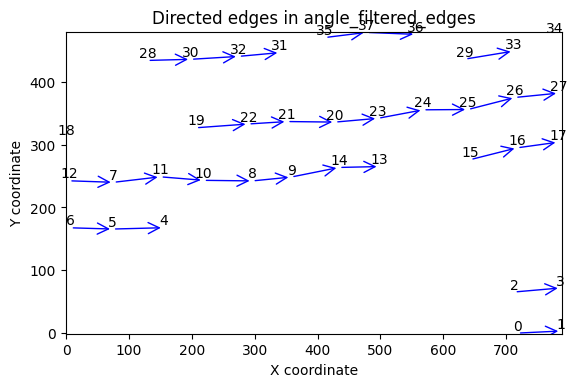

In [231]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the arrows using FancyArrowPatch
for (start, end) in traveling_algorithm_input:
    
    # Create an arrow patch
    arrow = FancyArrowPatch(start, end, arrowstyle='->', mutation_scale=20, color='b')

    # Add it to the axis
    ax.add_patch(arrow)

# Label the points with their indices
for i, coord in enumerate(normalized_coordinates):
    ax.text(coord[0], coord[1], str(i), ha='center', va='bottom')

# Set the plot title and labels
ax.set_title('Directed edges in angle_filtered_edges')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')

# Set the same scale for both axes and set the limit
ax.set_aspect('equal')
ax.set_xlim([min(x[0] for x in normalized_coordinates)-1, max(x[0] for x in normalized_coordinates)+1])
ax.set_ylim([min(y[1] for y in normalized_coordinates)-1, max(y[1] for y in normalized_coordinates)+1])

# Show the plot
plt.show()


In [246]:
import numpy as np
from itertools import combinations

average_distances = []
for edge in traveling_algorithm_input:
    start, end = edge
    distance = np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)
    average_distances.append(distance)

average_distance = np.mean(distance)

def calculate_Y(centers, d):
    """Calculate Y based on the maximum X value of the core + 1.5 * d."""
    max_x = max(centers, key=lambda x: x[0])[0]
    return max_x + 0.5 * d


# Calculate the average core-to-core distance
d = average_distance

# Calculate Y
Y = calculate_Y(normalized_coordinates, d)

rows = traveling_algorithm(traveling_algorithm_input, Y, d, 0.75 * d)

In [227]:
import matplotlib.pyplot as plt

def plot_rows_with_labels(rows):
    """
    Plots each row with labels indicating row and column numbers and distinguishes between real and imaginary points,
    with better label management to avoid overlapping.

    Parameters:
    rows (list of list of dicts): List where each sublist represents a row of points (centroids),
                                  and each point is a dictionary containing 'point', 'index', and 'is_imaginary'.
    """
    # Create a larger plot to better accommodate labels
    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Define colors and markers
    real_point_color = 'blue'
    imaginary_point_color = 'red'

    # Plot each point and add a label
    for row_idx, row in enumerate(rows):
        for col_idx, point_info in enumerate(row):
            x, y = point_info['point']
            original_index = point_info['index']
            is_imaginary = point_info['is_imaginary']
            color = imaginary_point_color if is_imaginary else real_point_color
            ax.plot(x, y, 'o', color=color)  # Use 'o' for both real and imaginary for uniformity
            
            # Offset for text label to reduce overlap, adjust as needed
            offset = 5
            ha = 'right' if col_idx % 2 == 0 else 'left'
            va = 'bottom' if row_idx % 2 == 0 else 'top'
            ax.text(x + offset if ha == 'right' else x - offset, 
                    y + offset if va == 'bottom' else y - offset, 
                    f'R{row_idx}C{col_idx}\n({original_index})',
                    fontsize=8, ha=ha, va=va, color=color)

    # Set plot labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title('Rows with Labels')

    # Show grid
    ax.grid(True)

    # Create a legend for real and imaginary points
    real_legend = plt.Line2D([0], [0], marker='o', color=real_point_color, label='Real Points', markersize=5)
    imaginary_legend = plt.Line2D([0], [0], marker='o', color=imaginary_point_color, label='Imaginary Points', markersize=5)
    ax.legend(handles=[real_legend, imaginary_legend])

    # Adjust axis limits to make sure all points are visible
    all_x = [point_info['point'][0] for row in rows for point_info in row]
    all_y = [point_info['point'][1] for row in rows for point_info in row]
    ax.set_xlim([min(all_x) - 10, max(all_x) + 10])
    ax.set_ylim([min(all_y) - 10, max(all_y) + 10])

    # Show the plot
    plt.show()


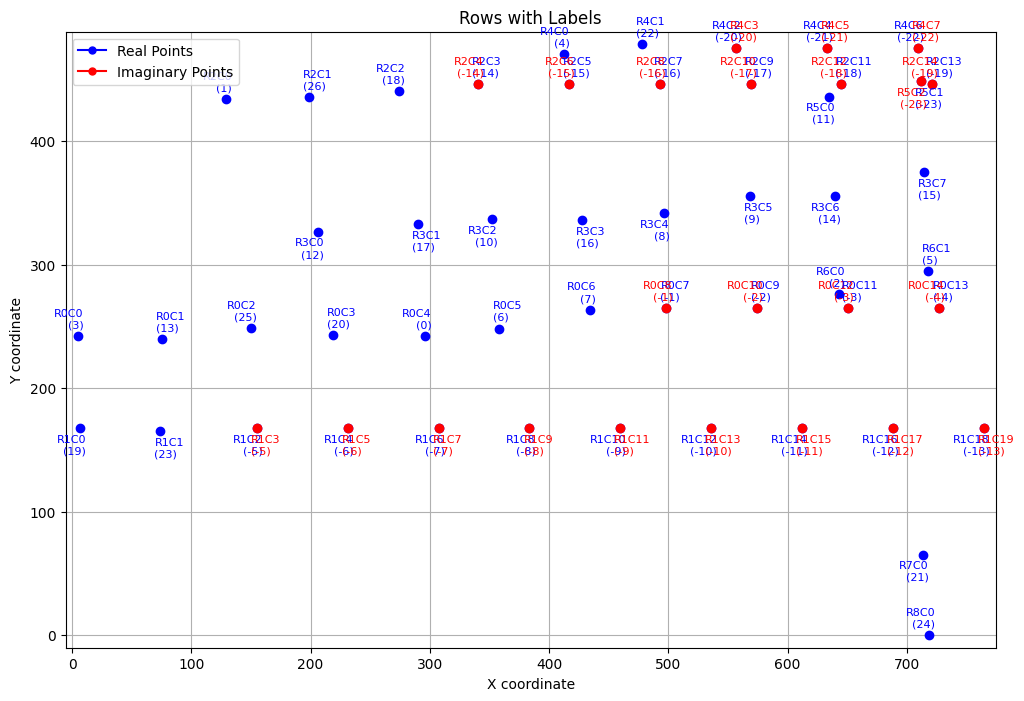

In [247]:
plot_rows_with_labels(rows)